<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
#!pip install imbalanced-learn -q
#!pip install swifter - q

In [2]:
import pandas as pd
from tqdm import notebook
import re
from time import time 
#import nltk
import numpy as np
from numpy.random import default_rng
import transformers
from sklearn.model_selection import train_test_split,cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score

from __future__ import unicode_literals, print_function
from spacy.lang.en import English

In [3]:
from imblearn.under_sampling import RandomUnderSampler

In [4]:
import torch
import transformers

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
import swifter

In [7]:
#import spacy
#from nltk.corpus import stopwords
#nltk.download('stopwords')
#from spacy.pipeline import Lemmatizer
#!python -m spacy download en_core_web_sm
#nlp = spacy.load("en_core_web_sm")

In [8]:
#tokenizer = transformers.BertTokenizer(
#    vocab_file='datasets/ds_bert/vocab.txt')

In [9]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [10]:
nlp = English()
nlp.add_pipe('sentencizer')

In [11]:
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [12]:
tokenizer.encode('He ran. He fell.')

[101, 2002, 2743, 1012, 2002, 3062, 1012, 102]

In [13]:
tokenizer.added_tokens_encoder

{'[PAD]': 0, '[UNK]': 100, '[CLS]': 101, '[SEP]': 102, '[MASK]': 103}

In [14]:
for enc in tokenizer.encode('He ran. He fell. Aaaaaaaaaaa...'):
    display((enc,tokenizer.decode([f'{enc}'])))

(101, '[CLS]')

(2002, 'he')

(2743, 'ran')

(1012, '.')

(2002, 'he')

(3062, 'fell')

(1012, '.')

(13360, 'aaa')

(11057, '##aa')

(11057, '##aa')

(11057, '##aa')

(11057, '##aa')

(1012, '.')

(1012, '.')

(1012, '.')

(102, '[SEP]')

In [15]:
RANDOM_STATE = 88

## Подготовка

In [16]:
start = time()
#df['text'].apply(lambda x: len(str(x).split()))
end = time()
end-start

0.0

In [17]:
url = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

In [18]:
df = pd.read_csv(url)

In [19]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [21]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [22]:
df['text'].duplicated().sum()

0

In [23]:
df['text'].str.lower().duplicated().sum()

46

In [24]:
df.isna().sum()

text     0
toxic    0
dtype: int64

In [25]:
def sents(string):
    doc = nlp(string)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

In [26]:
df['word_count'] = df['text'].apply(lambda x: x.count(' ') + 1)

In [27]:
df['sent_count'] = df['text'].apply(lambda x: len(sents(x)))

In [28]:
df['len'] = df['text'].apply(lambda x: len(x))

In [29]:
df['text'][154485]

'"\n\n ""Disappointing Players for Charlton"" \n\nI added in a section on the April Fools prank in the Crest\'s section, as well as splitting the directors of the boardroom into two sections, Charlton Athletic Ltd & CAFC PLC.\n\n"'

In [30]:
#df['text'][112719]

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        159292 non-null  object
 1   toxic       159292 non-null  int64 
 2   word_count  159292 non-null  int64 
 3   sent_count  159292 non-null  int64 
 4   len         159292 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 6.1+ MB


In [32]:
#df['text_lower'] = df['mid_text'].str.lower()
#df.drop_duplicates(subset='text_lower', inplace=True)
#df.reset_index(drop=True, inplace=True)

In [33]:
def distribution_plt(df_list, name, val_list, plt_xlim=1):

    x_max = min([series.max() for series in df_list])* plt_xlim

    fig, ax = plt.subplots(2,1,figsize=(10,8))
    ax[0].boxplot([df for df in df_list], vert=False)

    ax[0].set_yticklabels(val_list)
    ax[0].set_xlabel(name)
    ax[0].set_xlim([0, x_max])

    ax[1].hist([df for df in df_list], histtype='stepfilled', bins=500)
    ax[1].set_ylabel('частота')
    ax[1].set_xlabel(name)
    ax[1].set_xlim([0, x_max])

    
    plt.suptitle(f'Ящики с усами и гистограмма для признака "{name}"')
    plt.legend(val_list);
    #plt.xlim((0,x_max))

In [34]:
name_dict = {'word_count' : 'количество слов',
 'sent_count' : 'количество предложений',
 'len' : 'количество символов'}

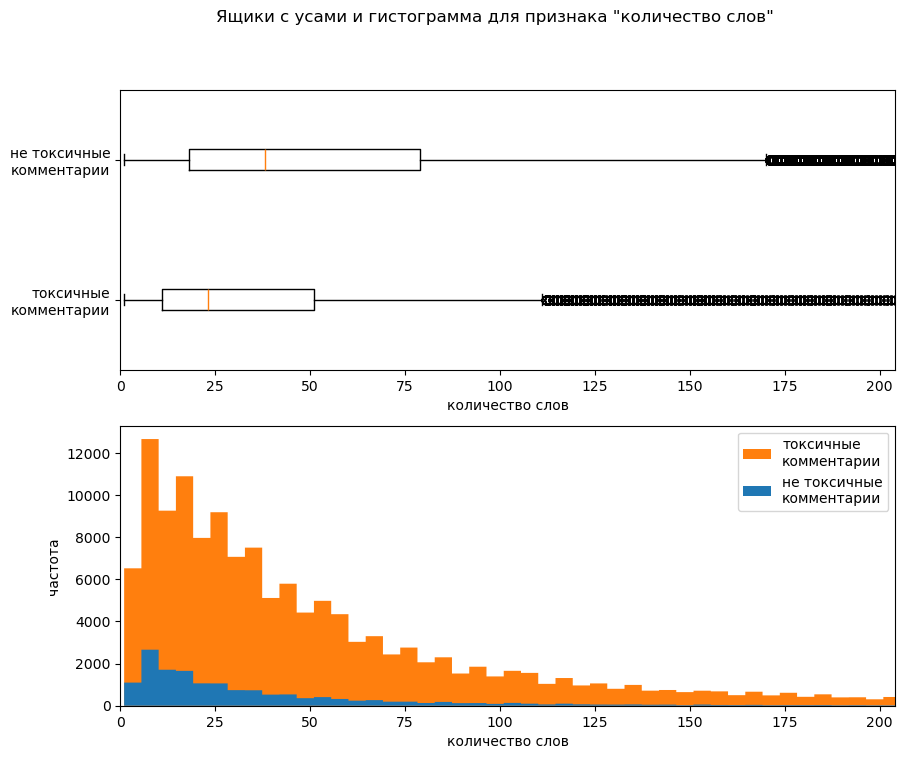

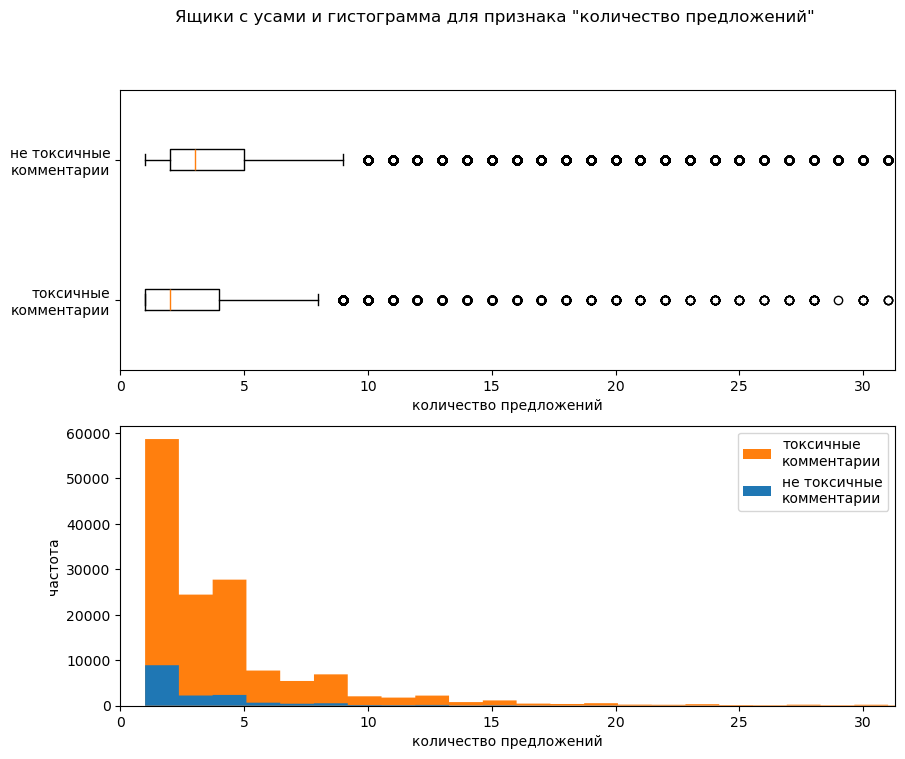

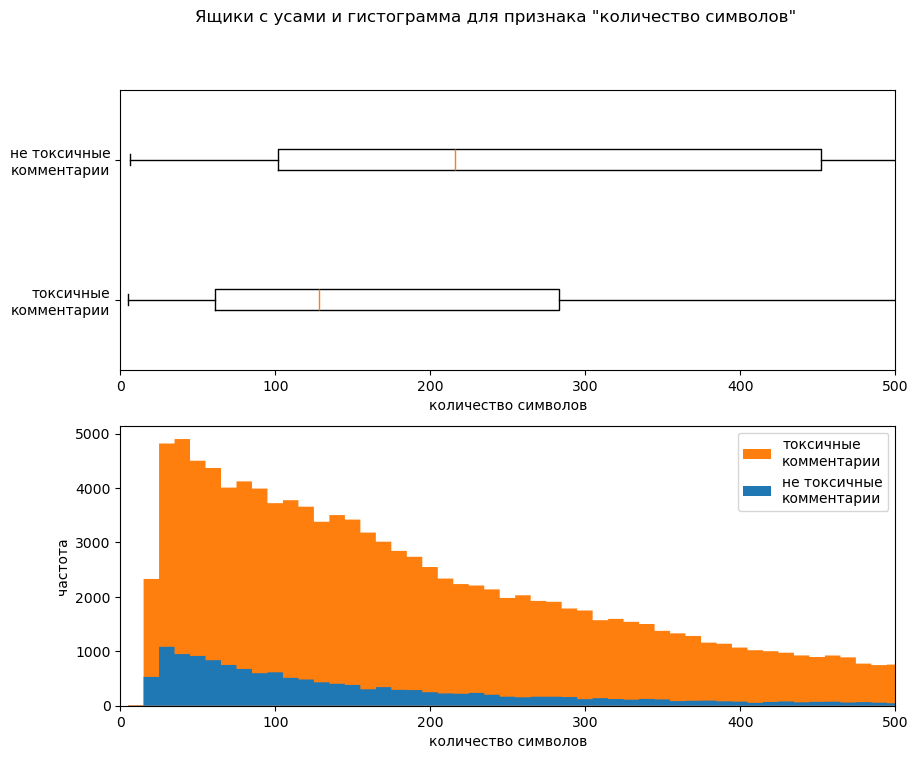

In [35]:
for col in ['word_count', 'sent_count', 'len']:
    
    distribution_plt(
        
        [df[df['toxic']==1][col], df[df['toxic']==0][col]],
        
        name_dict[col],
        
        ['токсичные\nкомментарии', 'не токсичные\nкомментарии'],
        
        0.1)

In [36]:
def word_rebuild(word_list):
    
    for word in range(len(word_list)):
        if len(word_list[word])>100:
            word_list[word] = ''.join(list(dict.fromkeys(word_list[word])))
    
    return word_list

In [37]:
#df1=df

In [ ]:
"attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 119547
}

In [945]:
config = transformers.BertConfig.from_dict({
      "attention_probs_dropout_prob": 0.1,
      "directionality": "bidi",
      "hidden_act": "gelu",
      "hidden_dropout_prob": 0.1,
      "hidden_size": 768,
      "initializer_range": 0.02,
      "intermediate_size": 3072,
      #"layer_norm_eps": 7e-2,
      "layer_norm_eps": 1e-12,
      #"layer_norm_eps": 4e-5,
      "max_position_embeddings": 512,
      "model_type": "bert",
      "num_attention_heads": 12,
      "num_hidden_layers": 12,
      "pad_token_id": 0,
      "pooler_fc_size": 768,
      "pooler_num_attention_heads": 12,
      "pooler_num_fc_layers": 3,
      "pooler_size_per_head": 128,
      "pooler_type": "first_token_transform",
      #"position_embedding_type": "absolute",
      #"transformers_version": "4.12.5",
      "use_cache":True,
      "type_vocab_size": 2,
      "vocab_size": 30522
}
)

def chunker(string, max_tokens):

    sents_ = sents(string)

    tokenized_sents = [tokenizer.encode(sent, add_special_tokens=True) for sent in sents_]
    
    toks=[]
    
    for token in tokenized_sents:
        if token not in toks:
            toks.append(token)
    
    if len(toks)>1:
        result = sum(toks,[])    
    else:
        result = toks[0]
    
    if len(result)>max_tokens:
        
        mid_sent = len(toks)//2
        
        if mid_sent == 1:
            
            if len(toks[1])<max_tokens:
                result = toks[1]    
            else:
                result = toks[0]
                
        elif mid_sent > 1:
            
            for s in range(1,mid_sent):

                mid_sents = toks[0]+toks[(mid_sent-s):mid_sent] + toks[mid_sent:(mid_sent+s)]+toks[-1]
                mid_sents_s = sum(mid_sents,[])
                if len(mid_sents_s) > max_tokens:
                    break
                    result = sum(mid_sents[:-1],[])
        
        else:
            result = sum(toks,[])
    #return result
    return result[:max_tokens][:-1]+[102]

In [39]:
def chunker(string, max_tokens):

#    max_tokens = max_tokens-1
    sents_ = sents(string)

    
    tokenized_sents = [tokenizer.encode(sent, add_special_tokens=False) for sent in sents_]
    
    toks=[]
    
    for token in tokenized_sents:
        if token not in toks:
            toks.append(token)
    

    result = sum(toks,[])    
    
    if len(result)>max_tokens:
        if len(sents_)>2:
            result = toks[0]+toks[-1]
    
            
    return [101] + result[:max_tokens-2] + [102]

In [990]:
def chunker(string, max_tokens=512):


    tokenized = tokenizer.encode(string, add_special_tokens=False)
    len_wo_tokens = max_tokens-2
    
    if len(tokenized)> len_wo_tokens:
        
        result = tokenized[:len_wo_tokens]
    else:
        result = tokenized

    return [101] + result + [102]

def chunker(string, max_tokens=512):


    
    tokenized = tokenizer.encode(string, add_special_tokens=False)
    len_wo_tokens = max_tokens-2
    
    if len(tokenized)> len_wo_tokens:
        
        result = tokenized[:(len_wo_tokens//2)] + tokenized[::-1][:(len_wo_tokens//2)][::-1]
    else:
        result = tokenized

    return [101] + result + [102]

In [42]:
chunker(df['text'][0], 8)

[101, 7526, 2339, 1996, 4229, 1012, 2676, 102]

In [43]:
#chunker(df['text'][0])

In [44]:
#OSError: We couldn't connect to 'https://huggingface.co' to load the files, and couldn't find them in the cached files.
#Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [45]:
#max_batch = 512

In [46]:
#init_config = config

In [47]:
#batch_size = 512

tokenized = X_train.swifter.apply(lambda x: chunker(x,max_batch))
#tokenized = text.apply(lambda x: chunker(x,max_batch))

max_len = 0

for tok in tokenized.values:
    if len(tok) > max_len:
        max_len = len(tok)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)


model = transformers.BertModel.from_pretrained('bert-base-uncased', config=init_config)
#model.config.max_position_embeddings = max_batch


batch_size = batch_size

embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

train_features = np.concatenate(embeddings)

test_tokenized = X_test.swifter.apply(lambda x: chunker(x,max_batch))


max_len = 0
for tok in test_tokenized.values:
    if len(tok) > max_len:
        max_len = len(tok)

padded = np.array([i + [0]*(max_len - len(i)) for i in test_tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

test_embeddings = []


for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            test_batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        test_embeddings.append(test_batch_embeddings[0][:,0,:].numpy())

test_features = np.concatenate(test_embeddings)

In [48]:
#train_features.shape

In [49]:
#test_features.shape

In [50]:
class bert_emb(object):


    def __init__(self, data, init_config,  batch_size=100, max_batch=512):

        self.data = data
        self.batch_size = batch_size
        self.max_batch = max_batch
        self.init_config = init_config 
        #self.tokenizer = chunker()
        #self.config.max_position_embeddings = max_batch
        self.model = transformers.BertModel.from_pretrained('bert-base-uncased', config=init_config)
        
    def embedder(self):

        #df.swifter.apply(lambda x: chunker(x,max_batch))

        tokenized = self.data.swifter.apply(lambda x: chunker(x, self.max_batch))
        
        max_len = 0
        
        for tok in tokenized.values:
            if len(tok) > max_len:
                max_len = len(tok)
    
        padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
        
        attention_mask = np.where(padded != 0, 1, 0)
        
        batch_size = self.batch_size
        
        embeddings = []
        
        for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
                batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
                attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
                
                with torch.no_grad():
                    batch_embeddings = self.model(batch, attention_mask=attention_mask_batch)
                
                embeddings.append(batch_embeddings[0][:,0,:].numpy())
    
        features = np.concatenate(embeddings)

        return features
        

In [51]:
#bert_emb(df['text'][0:5],config,1).embedder().shape

In [52]:
def logy(feats, target):
    lr = LogisticRegression(random_state=RANDOM_STATE,max_iter=feats.shape[1])
    lr.fit(feats, target)
    scores = cross_val_score(lr, feats, target, cv=5)
    return scores

In [53]:
#df[df['len']<=df['len'].quantile(0.9)].shape

In [54]:
# = df.sample(frac=0.5, random_state=RANDOM_STATE)

In [55]:
#df_test = df[df.index.isin(df_train.index)]

In [56]:
#df_train.shape,df_test.shape

In [57]:
#len_q_upper = df_train['len'].quantile(0.95)

In [58]:
#len_q_lower = df_train['len'].quantile(0.05)

In [59]:
#df_train.shape

In [60]:
#df_train = df_train[(df_train['len'] >= len_q_lower) & (df_train['len'] <= len_q_upper)]

In [952]:
df_for_test1 = df[df['toxic']==1].sample(n=512,random_state=RANDOM_STATE)

In [953]:
df_for_test = df[df['toxic']==0].sample(n=512,random_state=RANDOM_STATE)

In [954]:
df_for_test = pd.concat([df_for_test,df_for_test1])

In [956]:
X_train=df_for_test['text']
y_train = df_for_test['toxic']

In [959]:
X_test = df[~df.index.isin(X_test.index)].sample(n=1024,random_state=RANDOM_STATE)

In [960]:
y_test = X_test['toxic']
X_test = X_test['text']

In [629]:
#bert_emb(df['text'][0:1],config,batch_size=1,max_batch=10).embedder()[0]==bert_emb(df['text'][0:5],config,batch_size=1,max_batch=10).embedder()[0]

In [785]:
#samp = df.sample(n=1024, random_state=RANDOM_STATE)

In [984]:
#for i in samp.iloc[:,2:-1]:
#    display(i, samp[i].describe())

In [968]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'],
    df['toxic'],
    test_size = 0.50,
    random_state = RANDOM_STATE,
    stratify = df['toxic'])

In [969]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((79646,), (79646,), (79646,), (79646,))

In [970]:
sampler = RandomUnderSampler(random_state=RANDOM_STATE)
X_resample, y_resample = sampler.fit_resample(pd.DataFrame(X_train), pd.DataFrame(y_train))

In [1006]:
X_resample.shape, y_resample.shape

((16186, 1), (16186, 1))

In [975]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")

In [986]:
trial = X_train.sample(640,random_state = RANDOM_STATE)

In [988]:
y_trial = y_train[y_train.index.isin(trial.index)]

In [ ]:
bert_emb(X_train.sample(), config, 32,512).embedder()

In [991]:
embs = bert_emb(trial, config, 32,512).embedder()

Pandas Apply:   0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [992]:
embs.shape[0]

640

In [1007]:
logy(embs, y_trial).mean()

0.890625

In [ ]:
#array([0.95698925, 0.96236559, 0.99462366, 0.98918919, 0.95675676])

In [981]:
#np.array([0.9516129 , 0.95698925, 0.99462366, 0.98924731, 0.94623656]).mean()

In [982]:
#np.array([0.9516129 , 0.96236559, 0.99462366, 0.98924731, 0.9516129 ]).mean()

In [862]:
#array([0.94086022, 0.95698925, 0.98924731, 0.98924731, 0.96774194])

In [995]:
test_sample = X_test.sample(n=embs.shape[0], random_state=RANDOM_STATE)

In [996]:
embs_test = bert_emb(test_sample, config, 32, 512).embedder()

Pandas Apply:   0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [1004]:
y_ttrial = y_test[y_test.index.isin(test_sample.index)]

In [809]:
X_resample.shape, y_resample.shape

((930, 768), (930, 1))

In [776]:
pipe = Pipeline([('models', LogisticRegression(random_state=RANDOM_STATE,max_iter=1000))])

In [810]:
from sklearn.tree import DecisionTreeClassifier

In [997]:
param_grid = [

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )]#,
        #'models__C': range(2,7)  
    },
     {
        'models': [DecisionTreeClassifier(
            random_state=RANDOM_STATE#, 
            )]#,
        #'models__max_features': range(2,18)#,
        #'models__max_depth': range(,18)
    },
    

    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,25)   
    },


    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__degree': range(2,10),
        'models__kernel': ['poly','rbf','sigmoid']
    }
]

In [998]:
grid_search = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5,
    scoring='f1',

    n_jobs=-1
)
#grid_search.fit(X_resample[:X_test.shape[0]], y_resample['toxic'][:X_test.shape[0]])
grid_search.fit(embs, y_trial)
#grid_search.fit(embs, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('models',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=88))]),
             n_jobs=-1,
             param_grid=[{'models': [LogisticRegression(penalty='l1',
                                                        random_state=88,
                                                        solver='liblinear')]},
                         {'models': [DecisionTreeClassifier(random_state=88)]},
                         {'models': [KNeighborsClassifier()],
                          'models__n_neighbors': range(2, 25)},
                         {'models': [SVC(random_state=88)],
                          'models__degree': range(2, 10),
                          'models__kernel': ['poly', 'rbf', 'sigmoid']}],
             scoring='f1')

In [1000]:
pd.DataFrame(grid_search.cv_results_)[['rank_test_score', 'mean_test_score','params']].sort_values('rank_test_score').head(25)

,rank_test_score,mean_test_score,params
1,1,0.105883,{'models': DecisionTreeClassifier(random_state...
0,2,0.000000,"{'models': LogisticRegression(penalty='l1', ra..."
27,2,0.000000,"{'models': SVC(random_state=88), 'models__degr..."
28,2,0.000000,"{'models': SVC(random_state=88), 'models__degr..."
29,2,0.000000,"{'models': SVC(random_state=88), 'models__degr..."
30,2,0.000000,"{'models': SVC(random_state=88), 'models__degr..."
31,2,0.000000,"{'models': SVC(random_state=88), 'models__degr..."
32,2,0.000000,"{'models': SVC(random_state=88), 'models__degr..."
33,2,0.000000,"{'models': SVC(random_state=88), 'models__degr..."
34,2,0.000000,"{'models': SVC(random_state=88), 'models__degr..."


In [ ]:
#grid_search.best_estimator_

In [1001]:
grid_pred = grid_search.best_estimator_.predict(embs_test)#[:X_train.shape[0]])

In [1002]:
grid_pred.shape

(640,)

In [835]:
#0.6818181818181818

In [1005]:
f1_score(y_ttrial, grid_pred)
#f1_score(y_test[:X_train.shape[0]], grid_pred)

0.02877697841726619

In [182]:
1/0

ZeroDivisionError: division by zero

In [ ]:
svc = SVC(random_state=RANDOM_STATE, degree=4, kernel='poly')

In [ ]:
svc.fit(embs, y_train)

In [ ]:
preds_s = svc.predict(embs_test)

In [ ]:
f1_score(y_test, preds_s)

In [ ]:
1/0

## Обучение

In [ ]:
#from phik.report import plot_correlation_matrix
#from phik import phik_matrix

In [ ]:
#df.info()

phik_overview = phik_matrix(df[['toxic','word_count']],verbose=False)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(18, 14)
) 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text_lemm'], 
    df['toxic'], 
    random_state=RANDOM_STATE,
    stratify=df['toxic']
)

In [ ]:
sampler = RandomUnderSampler(random_state=RANDOM_STATE)
X_resample, y_resample = sampler.fit_resample(pd.DataFrame(X_train), pd.DataFrame(y_train)) 


In [ ]:
y_resample.value_counts()

In [ ]:
pd.DataFrame(y_test).value_counts()

## Выводы

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны